In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

# A simple graph that interrupts at node 3 if theres a numeric character in the input :

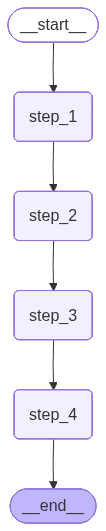

In [2]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    # Raise NodeInterrupt if the input contains any numeric digit
    if any(char.isdigit() for char in state['input']):
        raise NodeInterrupt(f"Received input that contains a digit: {state['input']}")
    print("---Step 3---")
    return state

def step_4(state: State) -> State:
    # Same logic as step_3, also with interrupt
    if any(char.isdigit() for char in state['input']):
        raise NodeInterrupt(f"Received input that contains a digit: {state['input']}")
    print("---Step 4---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_node("step_4", step_4)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", "step_4")
builder.add_edge("step_4", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [3]:
initial_input = {"input": "A daytona is 24 hrs long."}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'A daytona is 24 hrs long.'}
---Step 1---
{'input': 'A daytona is 24 hrs long.'}
---Step 2---
{'input': 'A daytona is 24 hrs long.'}
{'__interrupt__': (Interrupt(value='Received input that contains a digit: A daytona is 24 hrs long.', id='placeholder-id'),)}


/var/folders/g3/fm8vfsn162gbr3lvkzdfc_180000gn/T/ipykernel_32831/2078591268.py:22: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that contains a digit: {state['input']}")


In [4]:
state = graph.get_state(thread_config)
print(state.next)

('step_3',)


#### i inspected the state at this point and  i can see it is set to execute the 3rd node

In [5]:
print(state.tasks)

(PregelTask(id='031bc7a8-e02e-b3ff-1607-43753e3a8599', name='step_3', path=('__pregel_pull', 'step_3'), error=None, interrupts=(Interrupt(value='Received input that contains a digit: A daytona is 24 hrs long.', id='placeholder-id'),), state=None, result=None),)


### The interrupt is logged to the state 

### if we try to rerun it will not move fwd and just be stuck in this state

In [6]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'A daytona is 24 hrs long.'}
{'__interrupt__': (Interrupt(value='Received input that contains a digit: A daytona is 24 hrs long.', id='placeholder-id'),)}


/var/folders/g3/fm8vfsn162gbr3lvkzdfc_180000gn/T/ipykernel_32831/2078591268.py:22: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that contains a digit: {state['input']}")


In [7]:
state = graph.get_state(thread_config)
print(state.next)

('step_3',)


In [8]:
graph.update_state(
    thread_config,
    {"input": "the daytone is twenty four hours long."},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b342d-156c-6bb0-8003-fad8e039d08a'}}

In [9]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'the daytone is twenty four hours long.'}
---Step 3---
{'input': 'the daytone is twenty four hours long.'}
---Step 4---
{'input': 'the daytone is twenty four hours long.'}


### when we resolved the issue the graph worked perfectly

# LANGGRAPH API :

In [10]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [11]:
thread = await client.threads.create()
input_dict = {"input": "I love 1 direction songs."}

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=input_dict,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a261c-9e1c-733e-a485-cd7f0dde8228', 'attempt': 1}



Receiving new event of type: values...
{'input': 'I love 1 direction songs.'}



Receiving new event of type: values...
{'input': 'I love 1 direction songs.'}



Receiving new event of type: values...
{'input': 'I love 1 direction songs.'}



Receiving new event of type: values...
{'__interrupt__': [{'value': 'Received input that contains a digit: I love 1 direction songs.', 'id': 'placeholder-id'}]}





In [12]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state['next']


['step_3']

In [13]:
await client.threads.update_state(thread['thread_id'], {"input": "I love one direction songs"})

{'checkpoint': {'thread_id': '1748d6b3-9b2d-49a0-895a-1a0aa1e16e47',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b342d-1b62-6984-8003-74c69a026b46'},
 'configurable': {'thread_id': '1748d6b3-9b2d-49a0-895a-1a0aa1e16e47',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b342d-1b62-6984-8003-74c69a026b46'},
 'checkpoint_id': '1f0b342d-1b62-6984-8003-74c69a026b46'}

In [14]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a261c-a052-7196-98d0-14cdbea6e589', 'attempt': 1}



Receiving new event of type: values...
{'input': 'I love one direction songs'}



Receiving new event of type: values...
{'input': 'I love one direction songs'}



Receiving new event of type: values...
{'input': 'I love one direction songs'}





In [15]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'input': 'I love one direction songs'},
 'next': [],
 'tasks': [],
 'metadata': {'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': '755a156c-48c2-4cd2-8756-2034291060a6',
  'graph_id': 'dynamic_breakpoints',
  'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '0.6.10',
  'langgraph_api_version': '0.4.42',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',
  'langgraph_api_url': 'http://127.0.0.1:2024',
  'run_id': '019a261c-a052-7196-98d0-14cdbea6e589',
  'thread_id': '1748d6b3-9b2d-49a0-895a-1a0aa1e16e47',
  'source': 'loop',
  'step': 5,
  'parents': {}},
 'created_at': '2025-10-27T14:40:02.585173+00:00',
 'checkpoint': {'checkpoint_id': '1f0b342d-24b5-67ac-8005-a7818a298c2f',
  'thread_id': '1748d6b3-9b2d-49a0-895a-1a0aa1e16e47',
  'checkpoint_ns': ''},
 'parent_checkpoint': {'checkpoint_id':

being empty shows that the graph successfully executed

In [16]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state['next']


[]

### MADE A NEW .PY FILE TO SEE MY GRAPH IN THE LANGSMITH STUDIO PORTAL

# I tried this code on the Langsmith studio : 
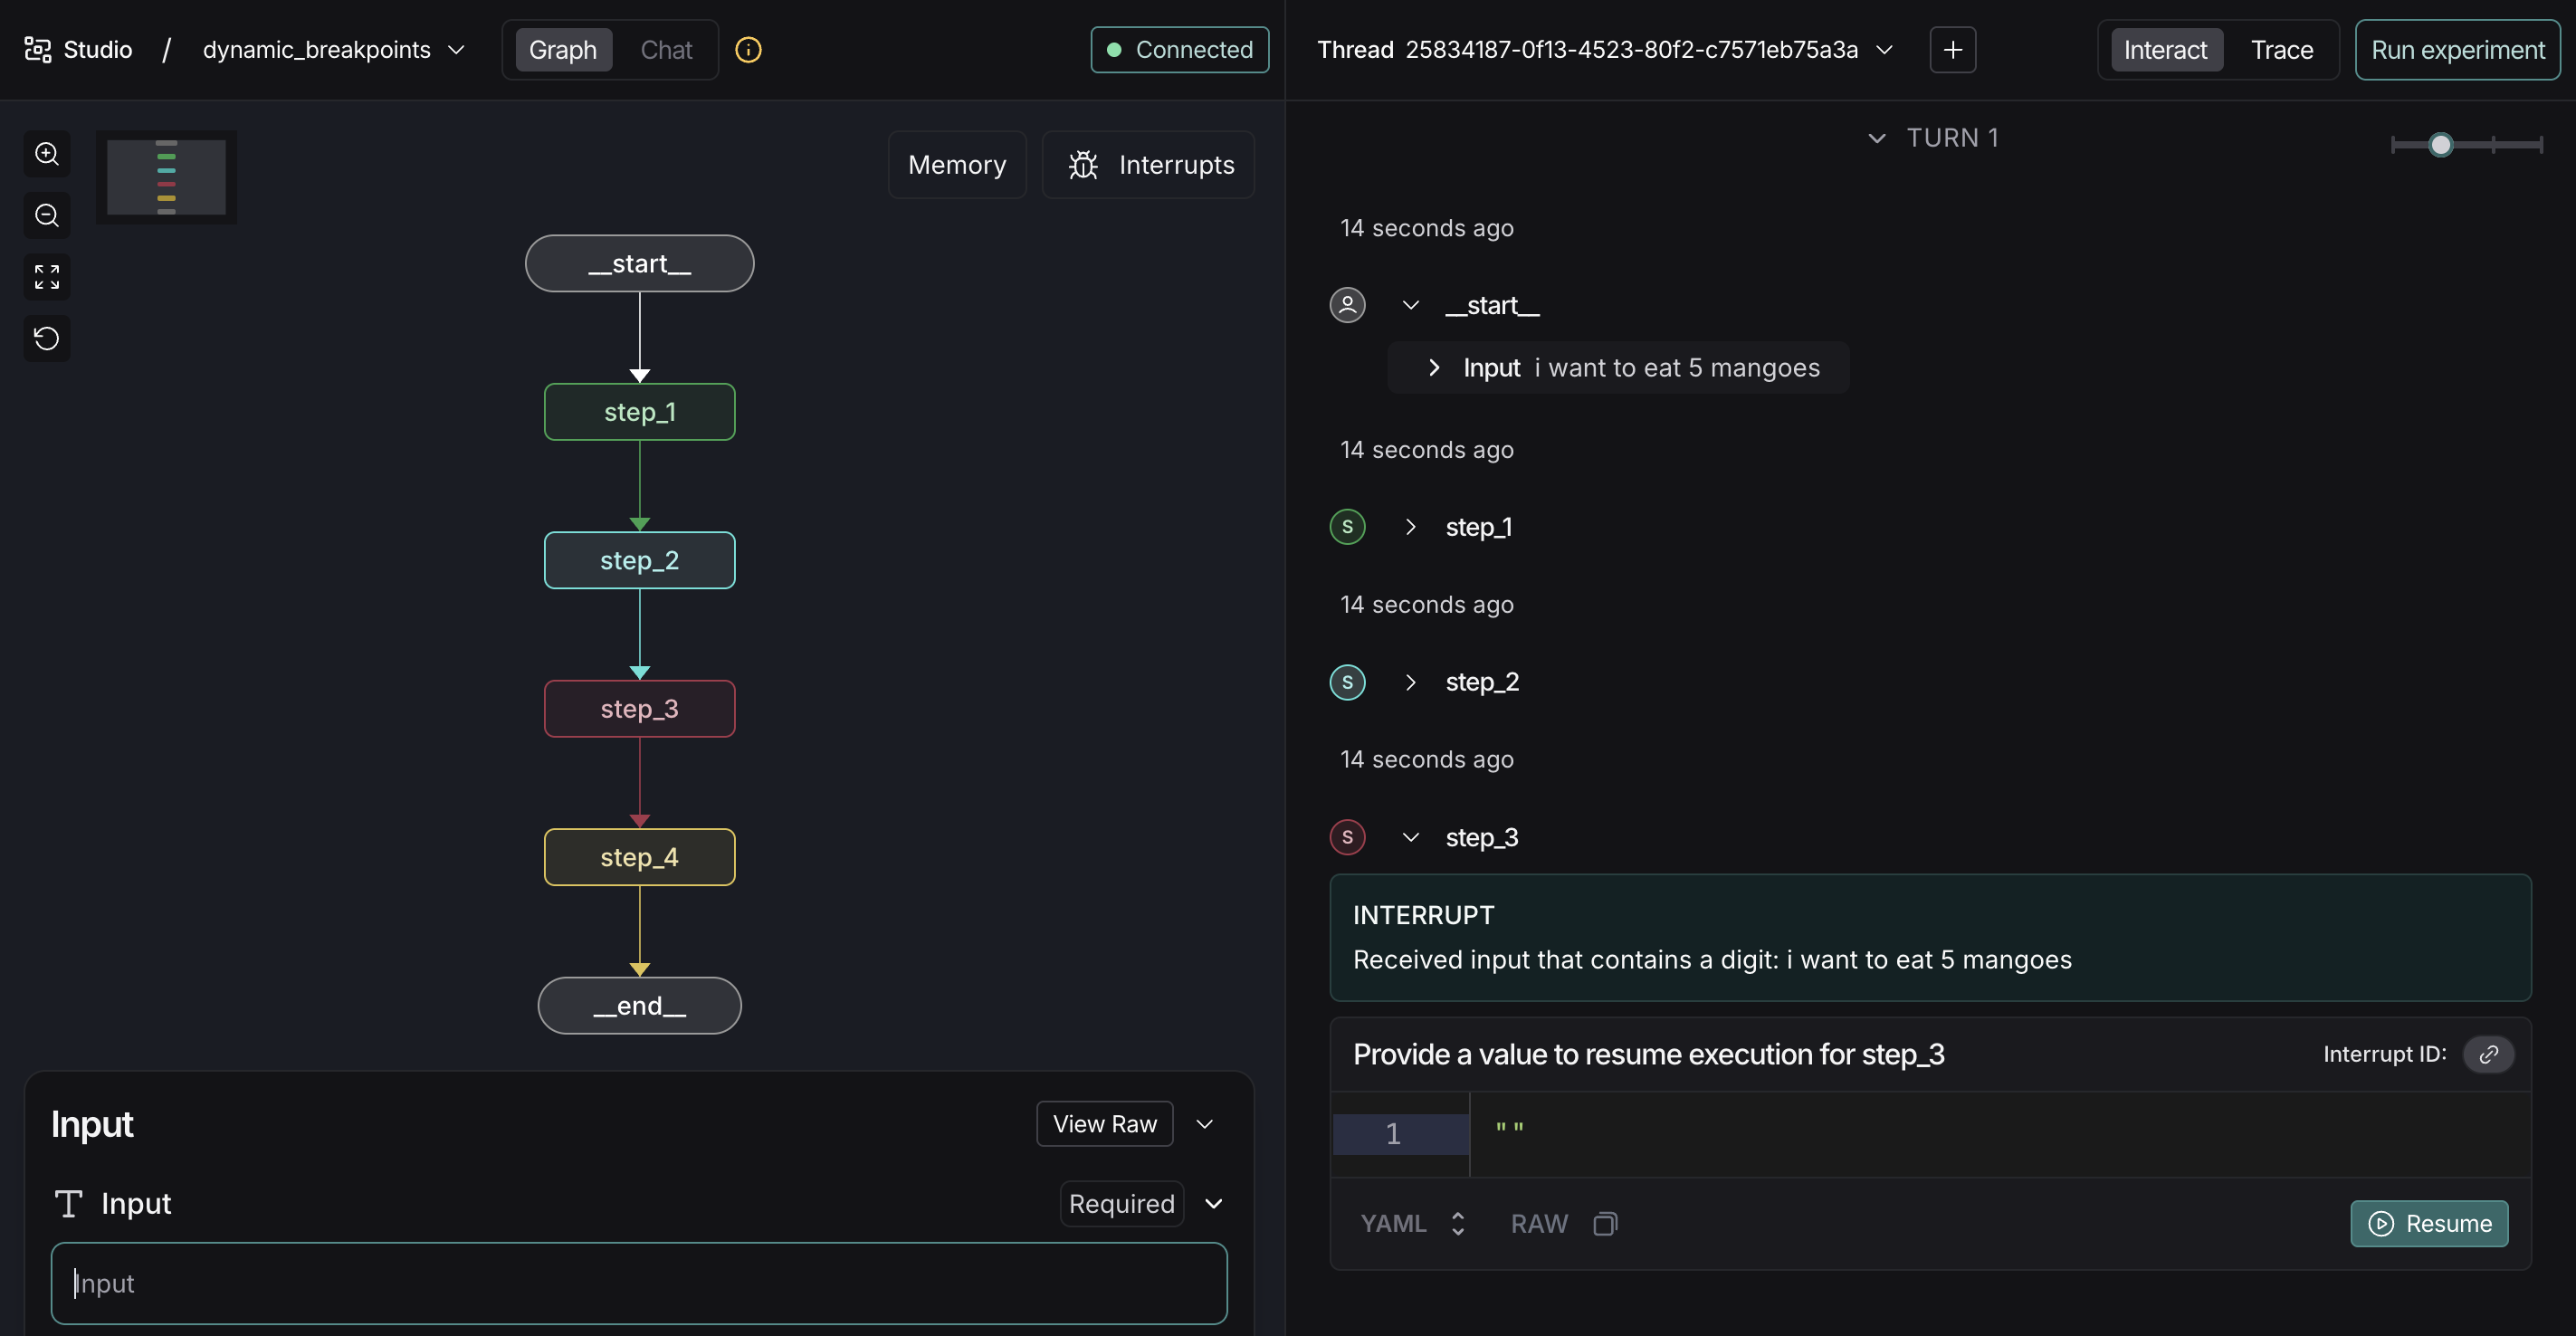
### as we can see it gets interrupted at node 3 for having a digit

### I had to change the state at node 3 and update it so that it has no digits in it 

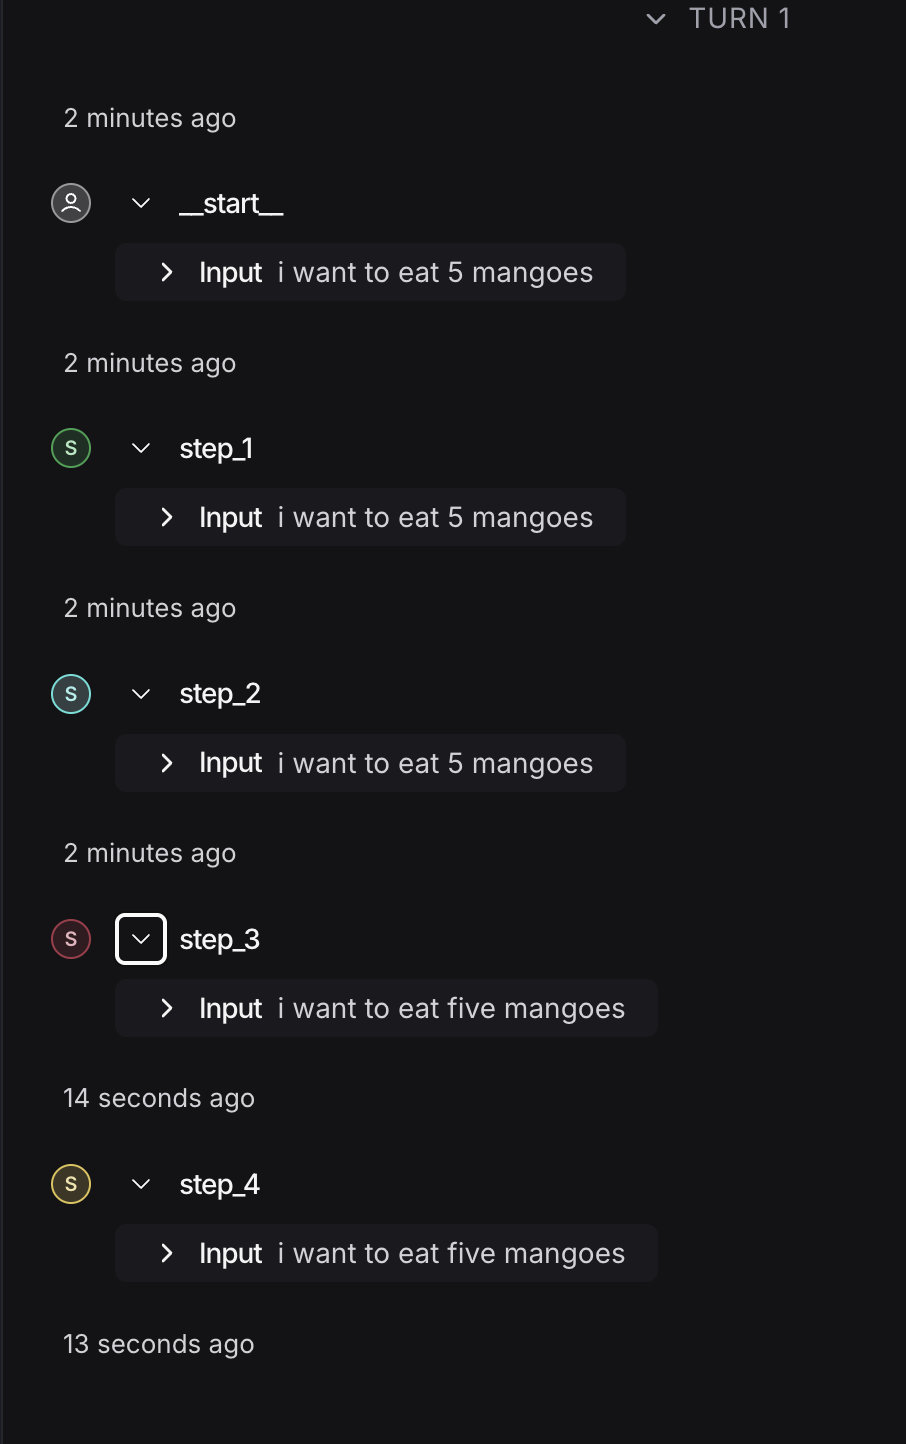

## and the code started working perfectly 